In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
import pandas as pd
import sympy
import seaborn as sns
sys.path.append('../')  

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

from test_data import *
from numpy.linalg import matrix_rank, svd
from itertools import product
from utils import plot_result_jacobi
from error_bounds import *
from matplotlib.colors import LinearSegmentedColormap
from jrc_analysis import *

#Defining colors for the plots: green = true , red = false
green=(100/255,250/255,100/255)#(0,1,0)
neutral_color = (1, 1, 1)  
red=(241/255,13/255,30/255)
cmap_green_red = LinearSegmentedColormap.from_list('RedGreen', [green,neutral_color,red], N=256)
cmap_red_green = LinearSegmentedColormap.from_list('GreenRed', [red,neutral_color,green], N=256)

In [179]:
def plot_classif_vs_noiselevel(plot_results,N):
    # Plotting
    plt.figure(figsize=(10, 6))
    # Get the unique fd_order values
    fd_orders = plot_results['fd_order'].unique()
    markers = ['s','o','>','x','P','*']
    # Plot each fd_order separately
    for i,fd_order in enumerate(fd_orders):
        subset = plot_results[plot_results['fd_order'] == fd_order]
        plt.plot(subset['noise_level'].values, subset['Correct_Classification'].values, marker=markers[i], label=f'FD Order {fd_order}')
    
    plt.title('Correct Classification vs Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel('Correct Classified PDEs')
    plt.xscale('log')
    plt.legend(title='FD Order')
    tick_positions = np.arange(0,N+1,1)  
    tick_labels = [f"{tick}/{N}" for tick in tick_positions]  
    plt.yticks(tick_positions, tick_labels)
    plt.grid(True)
    plt.show()

def plot_classif_vs_noiselevel_unique_nonunique(plot_results):
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5))
    plt.suptitle('Correct Classification vs Noise Level')
    markers = ['s','o','>','x','P','*']
    # Plot unique'
    plot_class = plot_results[plot_results['True_Class'] == "unique"]
    for i,fd_order in enumerate(fd_orders):
            N=3
            subset = plot_class[plot_results['fd_order'] == fd_order]
            ax1.plot(subset['noise_level'].values, subset['Correct_Classification'].values, marker=markers[i], label=f'FD Order {fd_order}')
            ax1.set_title("Unique")
            ax1.set_xlabel('Noise Level')
            ax1.set_ylabel('Correct Classified PDEs')
            ax1.set_xscale('log')
            ax1.legend(title='FD Order')
            tick_positions = np.arange(0,N+1,1)  
            tick_labels = [f"{tick}/{N}" for tick in tick_positions]  
            ax1.set_yticks(tick_positions)
            ax1.set_yticklabels(tick_labels)
    #Plot non unique
    plot_class = plot_results[plot_results['True_Class'] == "non unique"]
    for i,fd_order in enumerate(fd_orders):
            N=2
            subset = plot_class[plot_results['fd_order'] == fd_order]
            ax2.plot(subset['noise_level'].values, subset['Correct_Classification'].values, marker=markers[i], label=f'FD Order {fd_order}')
            ax2.set_title("Non unique")
            ax2.set_xlabel('Noise Level')
            ax2.set_ylabel('Correct Classified PDEs')
            ax2.set_xscale('log')
            ax2.legend(title='FD Order')
            tick_positions = np.arange(0,N+1,1)  
            tick_labels = [f"{tick}/{N}" for tick in tick_positions]  
            ax2.set_yticks(tick_positions) 
            ax2.set_yticklabels(tick_labels)
    plt.show()

In [2]:
def perform_experiment_jrc(noise_levels,fd_order,experiment_name,true_class,C2_param=1e-3,tickssize=16):
    results = pd.DataFrame(columns = ["True_Class", "Pred_Class","C2","noise_level","fd_order"])
    #Get data,
    u,x,t,formula = experiment_data(n_samples=150,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(f"Performing experiment {experiment_name} {formula} with order {fd_order}, C2 = {C2_param:.2e}")
    subtitle=f"Experiment {experiment_name} {formula}, Order {fd_order}, C2_param = {C2_param:.2e}"
    T,X = np.meshgrid(t,x)
    C_upper_bounds_deriv = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_order)
    
    for i,noise_level in enumerate(noise_levels):
        u_noise = add_noise(u,noise_level)
        eps = infinity_norm(u-u_noise)
        svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv,fd_order,dt,dx,eps,C2_param)   
        upper_minus_svs = upper_bounds - svs
        lower_minus_svs = lower_bounds - svs
        
        # Find out the classifcation
        # If the Jacobian has full rank for at least one data point →PDE unique
        if ((lower_minus_svs < 0) & (upper_minus_svs < 0)).any() :
            predicted_class = "unique"
        # If the PDE is algebraic and at every data point the Jacobian does not have full rank
        # -> PDE non unique
        elif ((upper_minus_svs > 0) & (lower_minus_svs > 0)).all() :
            #print("Prediction is non unique")
            #print("upper", upper_minus_svs)
            #print("lower", lower_minus_svs)
            predicted_class = "non unique"
        else:
            #print("upper_minus", upper_minus_svs)
            #print("lower_minus", lower_minus_svs)
            predicted_class = None
        results.loc[len(results)] = [true_class, predicted_class,C2_param,noise_level,fd_order]
    results["Correct_Classification"]=results["True_Class"]==results["Pred_Class"]
    return results    

### JRC

In [76]:
experiment_names= ['algebraic_nonunique_kdv','algebraic_nonunique_1','analytic_unique_1','analytic_unique_2','analytic_nonunique_1']
dic_experiments = {'algebraic_nonunique_kdv': "non unique",
                   'algebraic_nonunique_1': "non unique",
                   'analytic_unique_1': "unique",
                   'analytic_unique_2': "unique",
                   'analytic_nonunique_1': "unique"}
len_noise=10
noise_levels = [0] + [10**(i-10) for i in range(0,len_noise)]
fd_orders=[2,6,8,10,12]

In [77]:
all_results = pd.DataFrame(columns=["True_Class", "Pred_Class","C2","noise_level","fd_order","experiment"])
for experiment_name in experiment_names:
    for fd_order in fd_orders:
        true_class = dic_experiments[experiment_name]
        result_exp = perform_experiment_jrc(noise_levels,fd_order,experiment_name,true_class)
        result_exp["experiment"] = experiment_name
        all_results = pd.concat([all_results,result_exp])

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 2, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 6, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 10, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 12, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 2, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 6, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 8, C2 = 1.00e-03
Performing experiment algebraic_nonun

In [78]:
all_results["Correct_Classification"]=all_results["True_Class"]==all_results["Pred_Class"]

In [79]:
all_results

,True_Class,Pred_Class,C2,noise_level,fd_order,experiment,Correct_Classification
0,non unique,non unique,0.001,0.000000e+00,2,algebraic_nonunique_kdv,True
1,non unique,non unique,0.001,1.000000e-10,2,algebraic_nonunique_kdv,True
2,non unique,non unique,0.001,1.000000e-09,2,algebraic_nonunique_kdv,True
3,non unique,None,0.001,1.000000e-08,2,algebraic_nonunique_kdv,False
4,non unique,None,0.001,1.000000e-07,2,algebraic_nonunique_kdv,False
...,...,...,...,...,...,...,...
6,unique,None,0.001,1.000000e-05,12,analytic_nonunique_1,False
7,unique,None,0.001,1.000000e-04,12,analytic_nonunique_1,False
8,unique,None,0.001,1.000000e-03,12,analytic_nonunique_1,False
9,unique,None,0.001,1.000000e-02,12,analytic_nonunique_1,False


In [80]:
all_results.to_csv("results/all_results_plots_jrc.csv")

In [180]:
all_results= pd.read_csv("results/all_results_plots_jrc.csv")

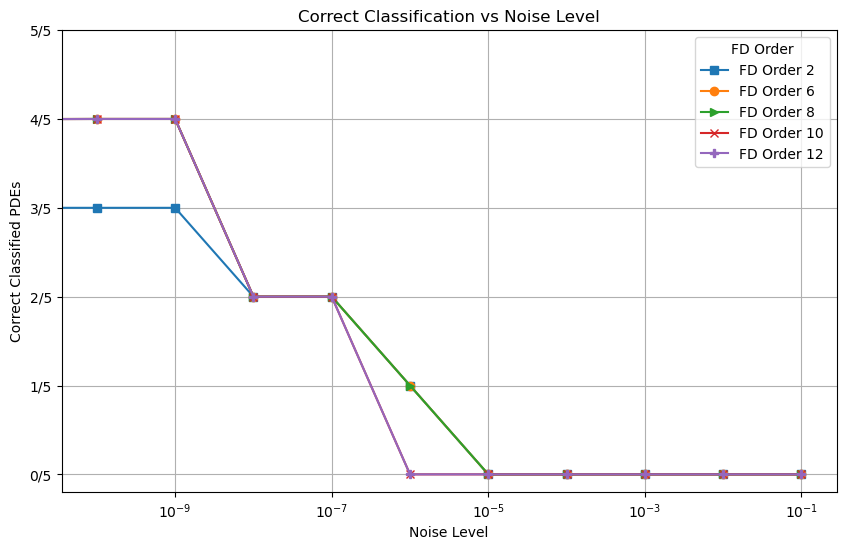

In [181]:
#Plot the number of classified equations per noise level
N = len(all_results["experiment"].unique())
columns = ["noise_level","fd_order","Correct_Classification"]
plot_results = all_results[columns].groupby(["noise_level","fd_order"]).sum().reset_index()
plot_results
plot_classif_vs_noiselevel(plot_results,N)

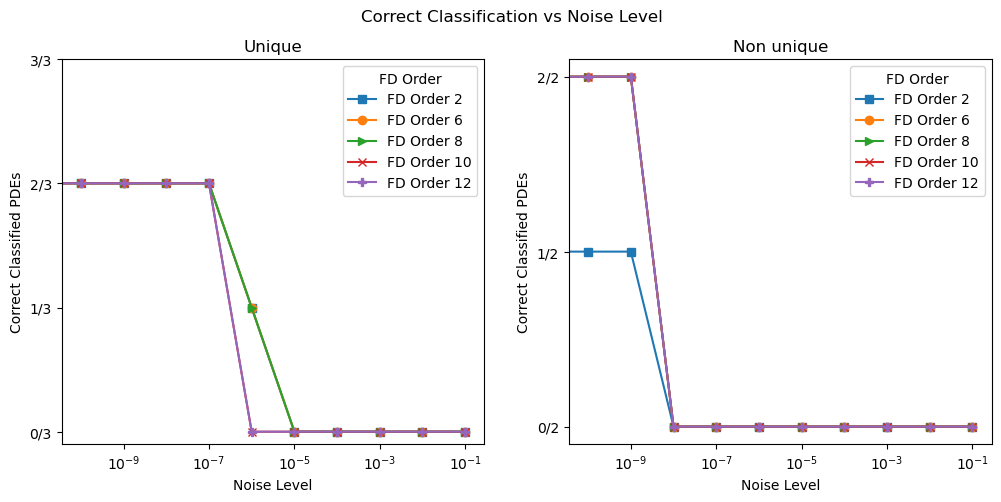

In [182]:
#Plot the number of classified equations per noise level
columns = ["noise_level","fd_order","True_Class","Correct_Classification"]
plot_results = all_results[columns].groupby(["noise_level","fd_order","True_Class"]).sum().reset_index()
plot_results
plot_classif_vs_noiselevel_unique_nonunique(plot_results)

### SFranCo

In [183]:
from sfranco_analysis import *

def perform_experiment_sfranco(noise_levels,experiment_name,true_class):
    #Get data
    u,x,t,formula = experiment_data(n_samples=150,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(f"Performing Experiment {experiment_name}")
    result = get_result_df(u,dx,noise_levels,orders=range(2,14,2),boundary=True)
    result.drop(["threshold_approx_nonuniq","threshold_approx_uniq"],axis=1)
    result["True_Class"]=true_class
    result['Pred_Class']=np.nan
    #if svs <= nonuniq and svs < uniq -> pde non unique
    condition = (result["ratio"] <= result["threshold_exact_nonuniq"]) & (result["ratio"] < result["threshold_exact_uniq"])
    result.loc[condition, 'Pred_Class'] = "non unique"
    # if svs >= uniq and svs > uniq -> pde unique
    condition = (result["ratio"]>=result["threshold_exact_uniq"]) & (result["ratio"]>result["threshold_exact_nonuniq"])
    result.loc[condition, 'Pred_Class'] = "unique"
    # Get if it is correctly classified
    result["Correct_Classification"]=result["True_Class"]==result["Pred_Class"]
    return result

In [184]:
experiment_names= ['linear_nonunique_1','linear_unique_1.1','linear_unique_1.2','linear_unique_1.3']
dic_experiments = {'linear_nonunique_1': "non unique",
                   'linear_unique_1.1': "unique",
                   'linear_unique_1.2': "unique",
                   'linear_unique_1.3': "unique",}

In [171]:
all_results = pd.DataFrame(columns=["True_Class", "Pred_Class","C2","noise_level","experiment"])
for experiment_name in experiment_names:
    true_class = dic_experiments[experiment_name]
    result_exp = perform_experiment_sfranco(noise_levels,experiment_name,true_class)
    result_exp["experiment"] = experiment_name
    all_results = pd.concat([all_results,result_exp])
all_results = all_results.rename(columns={"order":"fd_order"})

Performing Experiment linear_nonunique_1
Performing Experiment linear_unique_1.1
Performing Experiment linear_unique_1.2
Performing Experiment linear_unique_1.3


In [172]:
all_results.to_csv("results/all_results_plots_sfranco.csv")

In [185]:
all_results= pd.read_csv("results/all_results_plots_sfranco.csv")

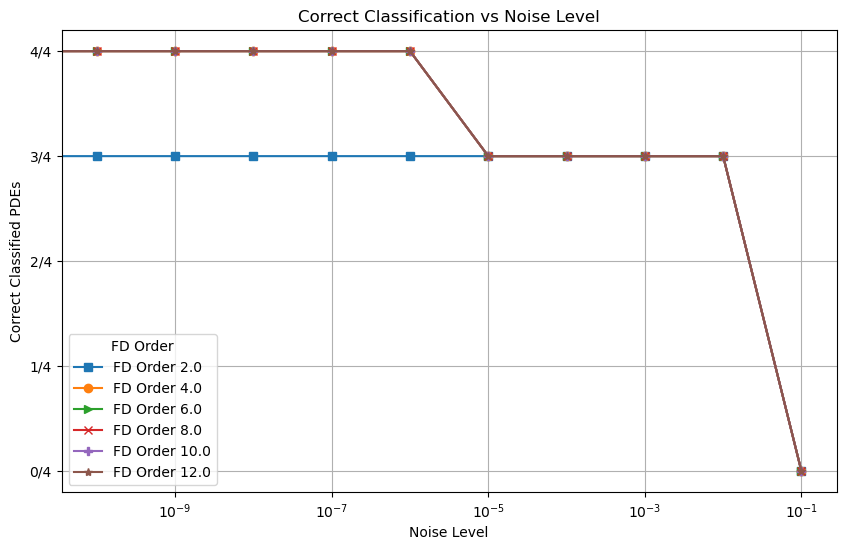

In [186]:
#Plot the number of classified equations per noise level
N = len(all_results["experiment"].unique())
columns = ["noise_level","fd_order","Correct_Classification"]
plot_results = all_results[columns].groupby(["noise_level","fd_order"]).sum().reset_index()
plot_results
plot_classif_vs_noiselevel(plot_results,N)

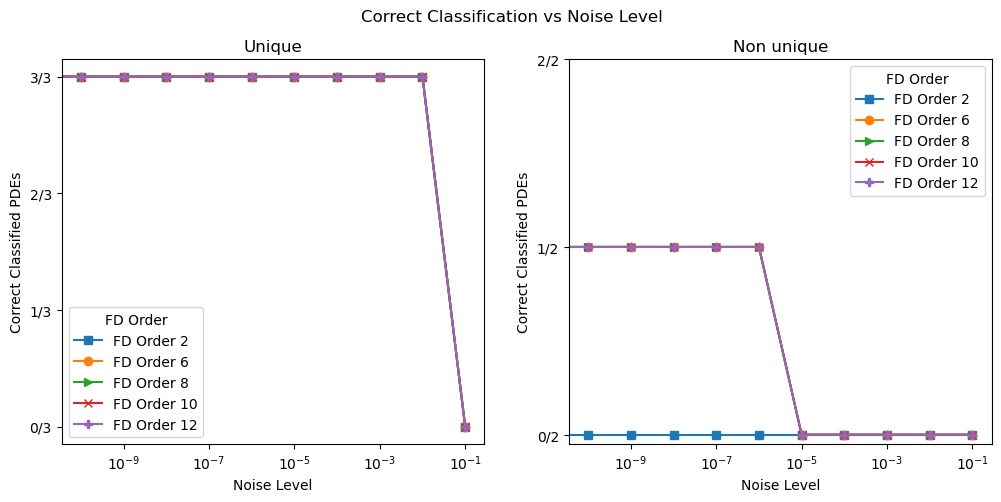

In [187]:
#Plot the number of classified equations per noise level while differentiation between unique and non unique
columns = ["noise_level","fd_order","True_Class","Correct_Classification"]
plot_results = all_results[columns].groupby(["noise_level","fd_order","True_Class"]).sum().reset_index()
plot_results
plot_classif_vs_noiselevel_unique_nonunique(plot_results)

In [189]:
all_results

,Unnamed: 0,True_Class,Pred_Class,C2,noise_level,experiment,fd_order,ratio,threshold_approx_uniq,threshold_exact_uniq,threshold_approx_nonuniq,threshold_exact_nonuniq,sv_max,sv_min,C,C1,Correct_Classification
0,0,non unique,NaN,0.312540,0.0,linear_nonunique_1,2.0,1.992018e-15,0.000052,0.000000,4.294934e-05,8.739726e-04,3125.401671,6.225856e-12,1562.700835,4688.102506,False
1,1,non unique,non unique,0.312540,0.0,linear_nonunique_1,4.0,2.982964e-15,0.000066,0.000066,2.882391e-06,7.866403e-07,2921.429157,8.714517e-12,1562.700835,4688.102506,True
2,2,non unique,non unique,0.312540,0.0,linear_nonunique_1,6.0,3.678943e-15,0.000067,0.000067,1.934485e-07,7.592705e-10,2731.795754,1.005012e-11,1562.700835,4688.102506,True
3,3,non unique,non unique,0.312540,0.0,linear_nonunique_1,8.0,4.428183e-15,0.000067,0.000067,1.298312e-08,7.599963e-13,2554.470811,1.131166e-11,1562.700835,4688.102506,True
4,4,non unique,NaN,0.312540,0.0,linear_nonunique_1,10.0,5.068212e-15,0.000067,0.000067,8.713504e-10,7.780120e-16,2388.656296,1.210622e-11,1562.700835,4688.102506,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,61,unique,NaN,2484.903766,0.1,linear_unique_1.3,4.0,6.653190e-01,0.293770,0.000000,5.183566e-03,1.000000e+00,7318.190956,4.868931e+03,2798.371969,8395.115908,False
260,62,unique,NaN,2484.903766,0.1,linear_unique_1.3,6.0,5.795577e-01,0.293770,0.000000,5.183566e-03,1.000000e+00,8231.886934,4.770854e+03,2798.371969,8395.115908,False
261,63,unique,NaN,2484.903766,0.1,linear_unique_1.3,8.0,5.311919e-01,0.293770,0.000000,5.183566e-03,1.000000e+00,8794.330966,4.671477e+03,2798.371969,8395.115908,False
262,64,unique,NaN,2484.903766,0.1,linear_unique_1.3,10.0,4.987473e-01,0.293770,0.000000,5.183566e-03,1.000000e+00,9170.250605,4.573637e+03,2798.371969,8395.115908,False
